# 📝 **Exploring interpretability: GLM and GAM**  

The objective of this notebook is to analyze the results of GLM and GAM focusing on interpretability. For this,  we will explore methods like Feature Importance, partial dependence plot and SHapley Additive exPlanations (SHAP). It´s important to notice that the results and optimizations considered here are explicated in ``Optuna_Results_Analysis_IT_GLM_GAM_SR`` file. 

***

### 📚 **Importing libraries & Data**

In [1]:
import optuna

import pandas as pd
import numpy as np
import math
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.cluster import Birch

from statsmodels.genmod.families.links import Identity

c:\Users\julia24002\.conda\envs\glm_gam\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#!pip install seaborn

In [3]:
df = pd.read_csv("../data/train.csv")
display(df)

,number_of_elements,mean_atomic_mass,wtd_mean_atomic_mass,gmean_atomic_mass,wtd_gmean_atomic_mass,entropy_atomic_mass,wtd_entropy_atomic_mass,range_atomic_mass,wtd_range_atomic_mass,std_atomic_mass,...,wtd_mean_Valence,gmean_Valence,wtd_gmean_Valence,entropy_Valence,wtd_entropy_Valence,range_Valence,wtd_range_Valence,std_Valence,wtd_std_Valence,critical_temp
0,4,88.944468,57.862692,66.361592,36.116612,1.181795,1.062396,122.90607,31.794921,51.968828,...,2.257143,2.213364,2.219783,1.368922,1.066221,1,1.085714,0.433013,0.437059,29.00
1,5,92.729214,58.518416,73.132787,36.396602,1.449309,1.057755,122.90607,36.161939,47.094633,...,2.257143,1.888175,2.210679,1.557113,1.047221,2,1.128571,0.632456,0.468606,26.00
2,4,88.944468,57.885242,66.361592,36.122509,1.181795,0.975980,122.90607,35.741099,51.968828,...,2.271429,2.213364,2.232679,1.368922,1.029175,1,1.114286,0.433013,0.444697,19.00
3,4,88.944468,57.873967,66.361592,36.119560,1.181795,1.022291,122.90607,33.768010,51.968828,...,2.264286,2.213364,2.226222,1.368922,1.048834,1,1.100000,0.433013,0.440952,22.00
4,4,88.944468,57.840143,66.361592,36.110716,1.181795,1.129224,122.90607,27.848743,51.968828,...,2.242857,2.213364,2.206963,1.368922,1.096052,1,1.057143,0.433013,0.428809,23.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21258,4,106.957877,53.095769,82.515384,43.135565,1.177145,1.254119,146.88130,15.504479,65.764081,...,3.555556,3.223710,3.519911,1.377820,0.913658,1,2.168889,0.433013,0.496904,2.44
21259,5,92.266740,49.021367,64.812662,32.867748,1.323287,1.571630,188.38390,7.353333,69.232655,...,2.047619,2.168944,2.038991,1.594167,1.337246,1,0.904762,0.400000,0.212959,122.10
21260,2,99.663190,95.609104,99.433882,95.464320,0.690847,0.530198,13.51362,53.041104,6.756810,...,4.800000,4.472136,4.781762,0.686962,0.450561,1,3.200000,0.500000,0.400000,1.98
21261,2,99.663190,97.095602,99.433882,96.901083,0.690847,0.640883,13.51362,31.115202,6.756810,...,4.690000,4.472136,4.665819,0.686962,0.577601,1,2.210000,0.500000,0.462493,1.84


### 📊 **Target distribution for clustering (GLM)** 

For analysis the results in clustering for GLM, we can plot the target distribution for each group. For the that, it´s necessary to train the Birch with the params discovered by Optuna and the same data used in optimization process.

First of all, it´s necessary to make the train test split, using the same seed and test size.

In [4]:
TEST_SIZE = 0.1

In [5]:
X = df.drop(columns="critical_temp")
y = df["critical_temp"]
X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=TEST_SIZE, random_state=1702
    )
y_test = np.clip(y_test, 1e-6, None)
y_train = np.clip(y_train, 1e-6, None)

After that we can import the params of the Optuna best trial.

In [6]:
study_name = "optimization_clusters_glm_teste21_07_2025_16_46_28"
storage_url = "sqlite:///../Optuna_files/optimization_glm_bayesian.db"

study_glm = optuna.load_study(study_name=study_name, storage=storage_url)

In [7]:
study_glm.best_params

{'clusterer': 'birch',
 'n_clusters_birch': 10,
 'branching_factor': 700,
 'threshold': 0.18251719168858943,
 'distribution': 'gaussian',
 'link_gaussian': 'identity'}

The chosen clusterer was **Balanced Iterative Reducing and Clustering using Hierarchies (BIRCH)**

And with that, train the chosen clusterer (Birch) with the chosen params.

In [8]:
birch_glm = Birch(n_clusters=10,
                    branching_factor=700,
                    threshold=0.18251719168858943)

In [9]:
cluster_labels = birch_glm.fit_predict(X_train)

unique_clusters = np.unique(cluster_labels)
valid_clusters = [c for c in unique_clusters if c != -1]

With that, we can visualize the target distributions for each cluster.

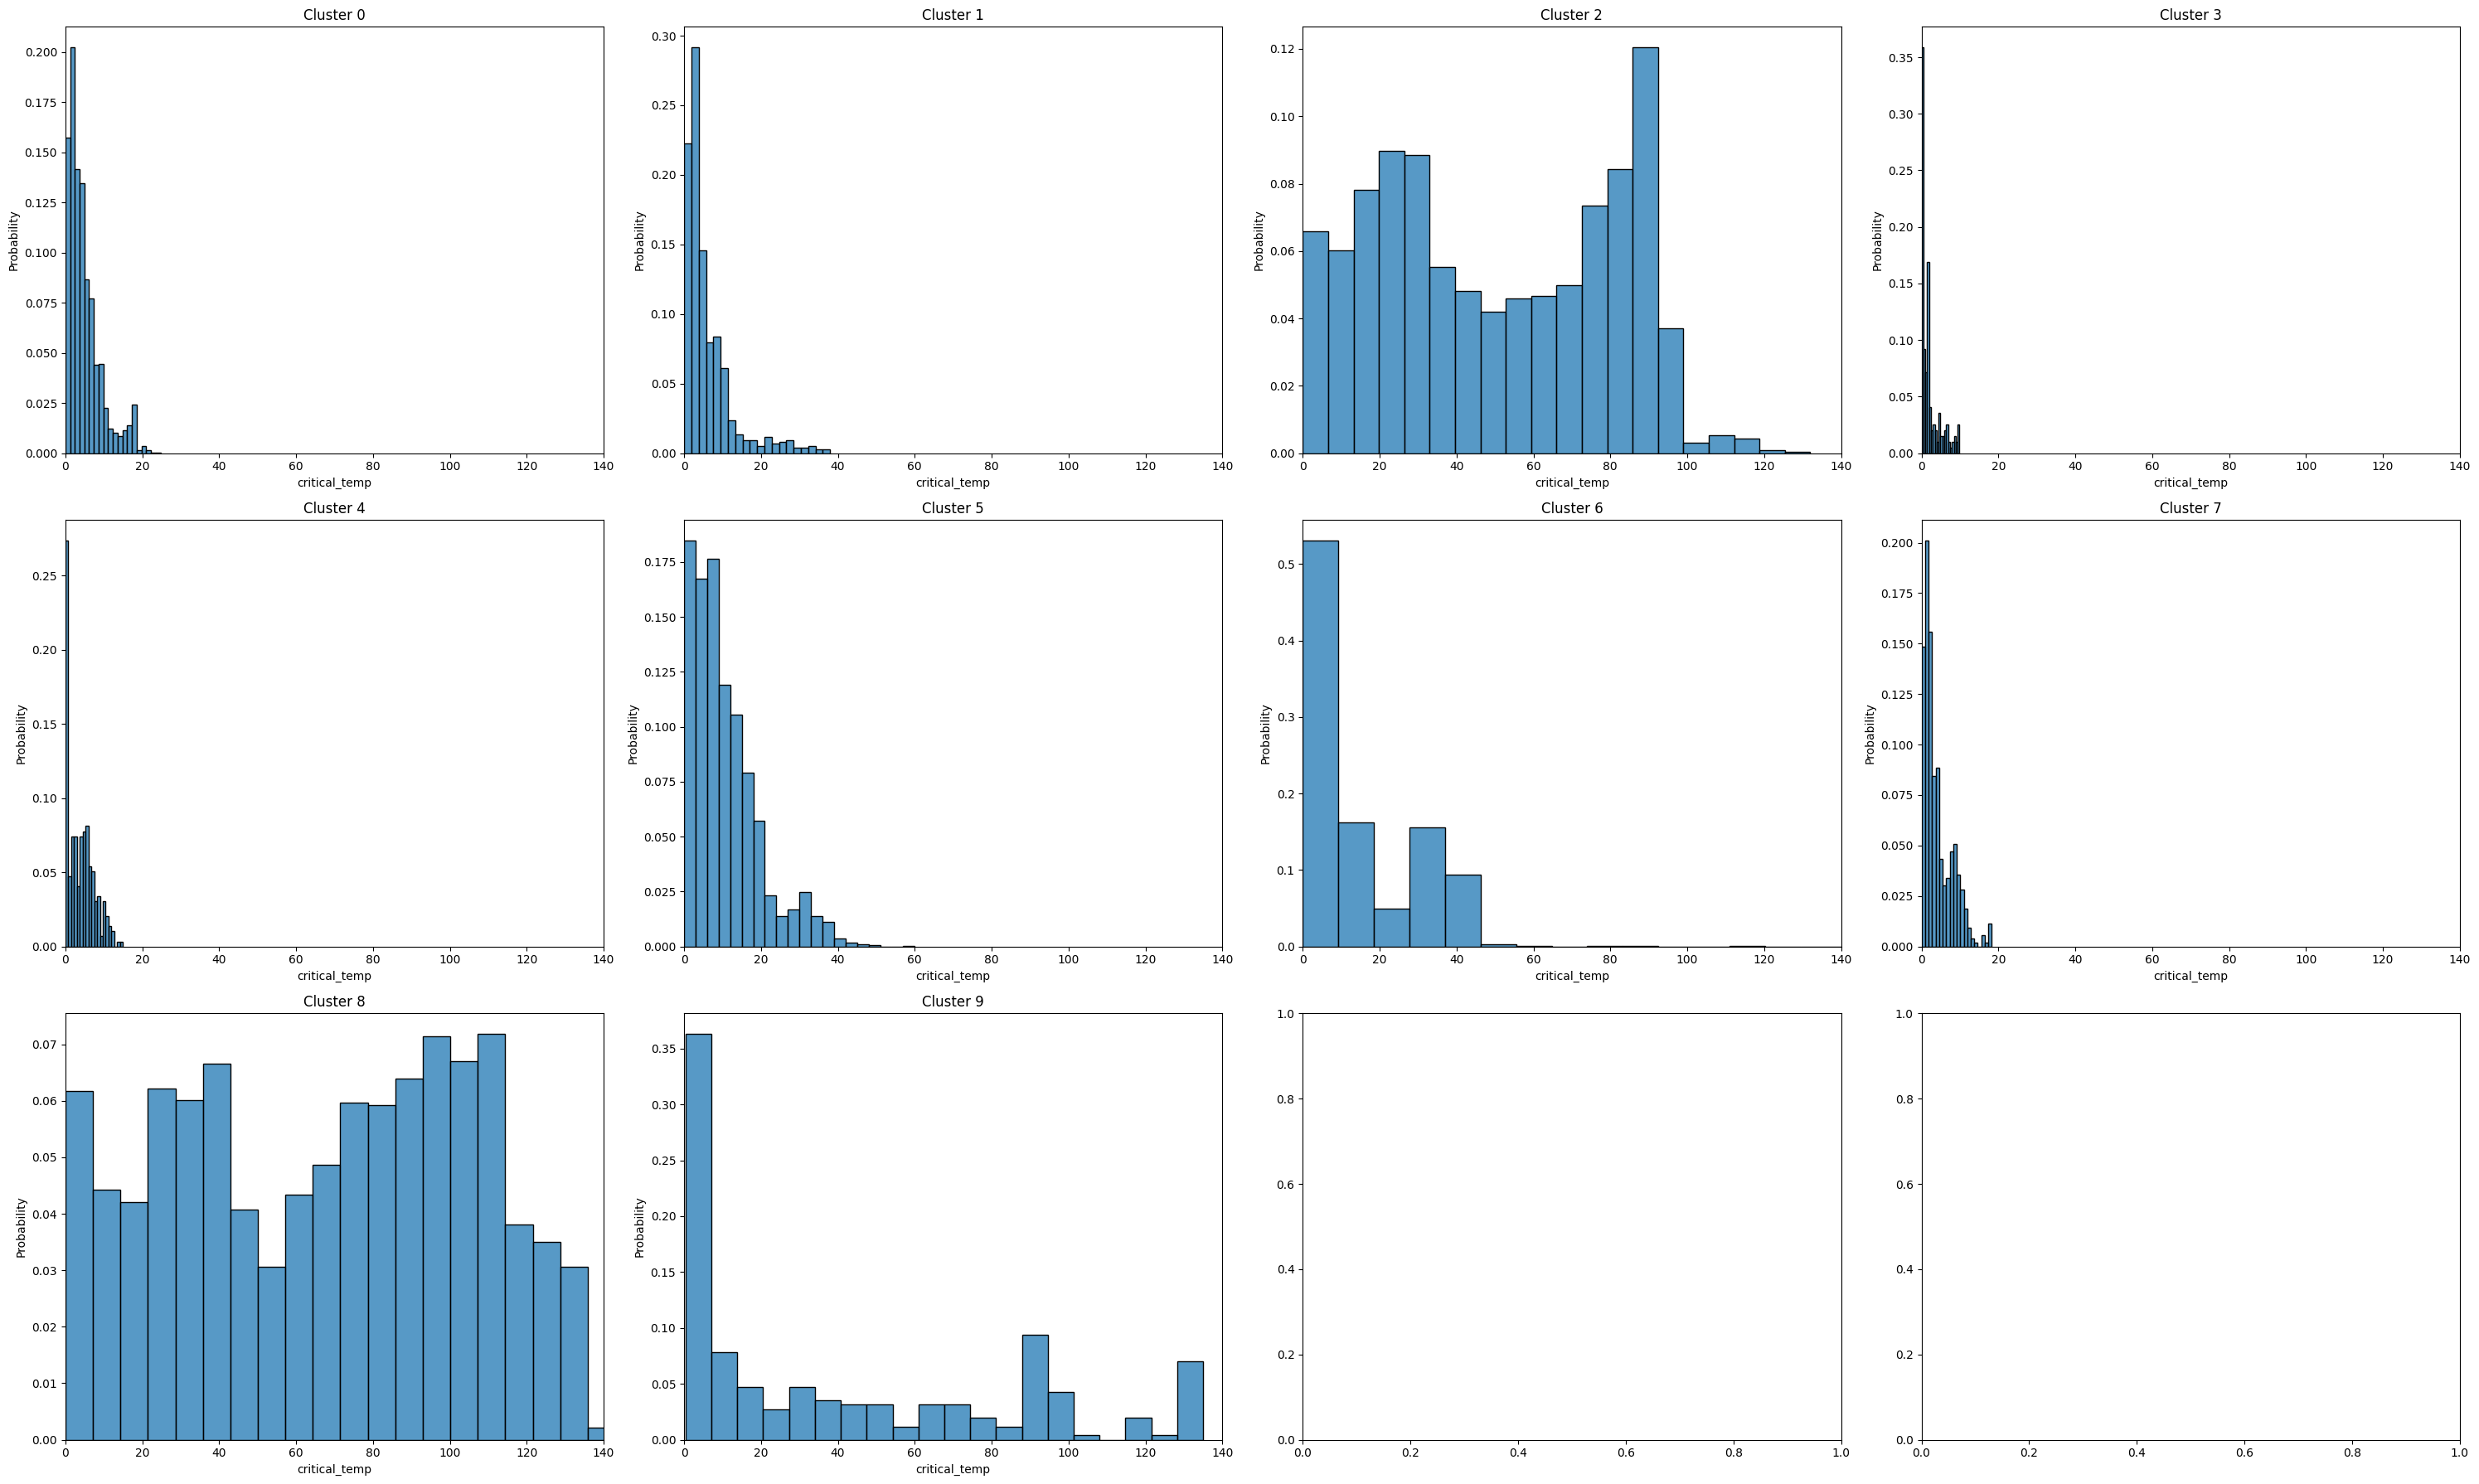

In [10]:
fig, axs = plt.subplots(3, 4, figsize=(30, 18))
axs = axs.flatten()

count = 0
for cluster in valid_clusters: 
    idx = np.where(cluster_labels == cluster)[0]

    X_cluster = X_train.iloc[idx]
    y_cluster = y_train.iloc[idx]

    sns.histplot(y_cluster, ax=axs[count], kde=False, stat="probability", bins=20)  
    axs[count].set_title(f"Cluster {cluster}")
    axs[count].set_xlim(0, 140)

    count += 1
    if count >= len(X_train.columns): 
        break

plt.tight_layout()
plt.show()


Using the same X-axis interval for all the plots, it is clear that the distributions are very different. However, the ranges used are not well defined, so it is not possible to identify the clustering criteria based on this plot alone.

So, some other tools can be used for that type of analysis.

In the reference [1] a method that combines different interpretable measures, as Shapley additive explanations (SHAP), permutation feature importance and quantitatively evaluating partial dependence plots (QPDP) was used for safety climate analysis. Similarly, we can implement these ideas in this case.

First of all, in GLM case, we can edit the original script to verify the most import features for each cluster.

In [11]:
import sys
sys.path.append('..//Main_Scripts')

from script_glm_interpretability import *

In [12]:
glm = Clustering_GLM(clusterer=clone(birch_glm),
                    distribution = sm.families.Gaussian(link=Identity())
    )

In [13]:
glm.fit(X_train, y_train)

,clusterer,Birch(branchi...1719168858943)
,distribution,<statsmodels....0018C16546CE0>
,threshold,0.18251719168858943
,branching_factor,700
,n_clusters,10
,compute_labels,True
,copy,'deprecated'


Let´s test!

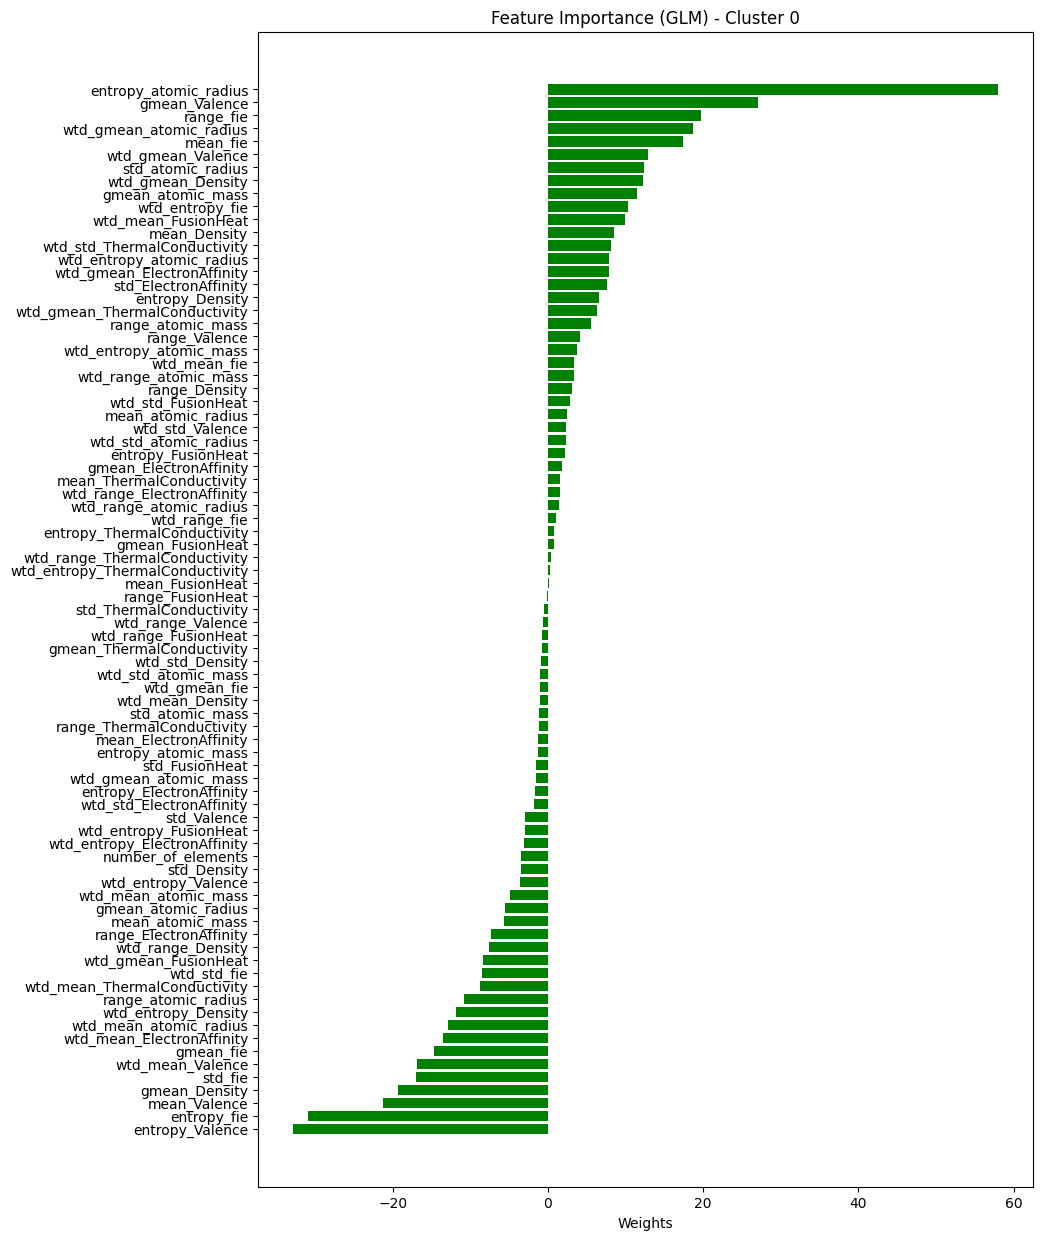

,Feature,Feature Importance
25,entropy_atomic_radius,57.973256
75,entropy_Valence,32.801568
15,entropy_fie,30.955424
73,gmean_Valence,27.027919
71,mean_Valence,21.248236
17,range_fie,19.708954
33,gmean_Density,19.327632
24,wtd_gmean_atomic_radius,18.710692
11,mean_fie,17.427048
19,std_fie,16.962003


In [14]:
df_fi0 = glm.feature_importance(cluster=0, k=10)
display(df_fi0)

Here, we can visualize the weight of each feature within a cluster and identify the top-$k$ most important ones, defined by the absolute value of their weights.

We can do this now with the other clusters! By that, we can visualize the plots and, after that, make an histogram with the most frequent features, considering all the clusters. 

In [15]:
df_fi = df_fi0.copy()

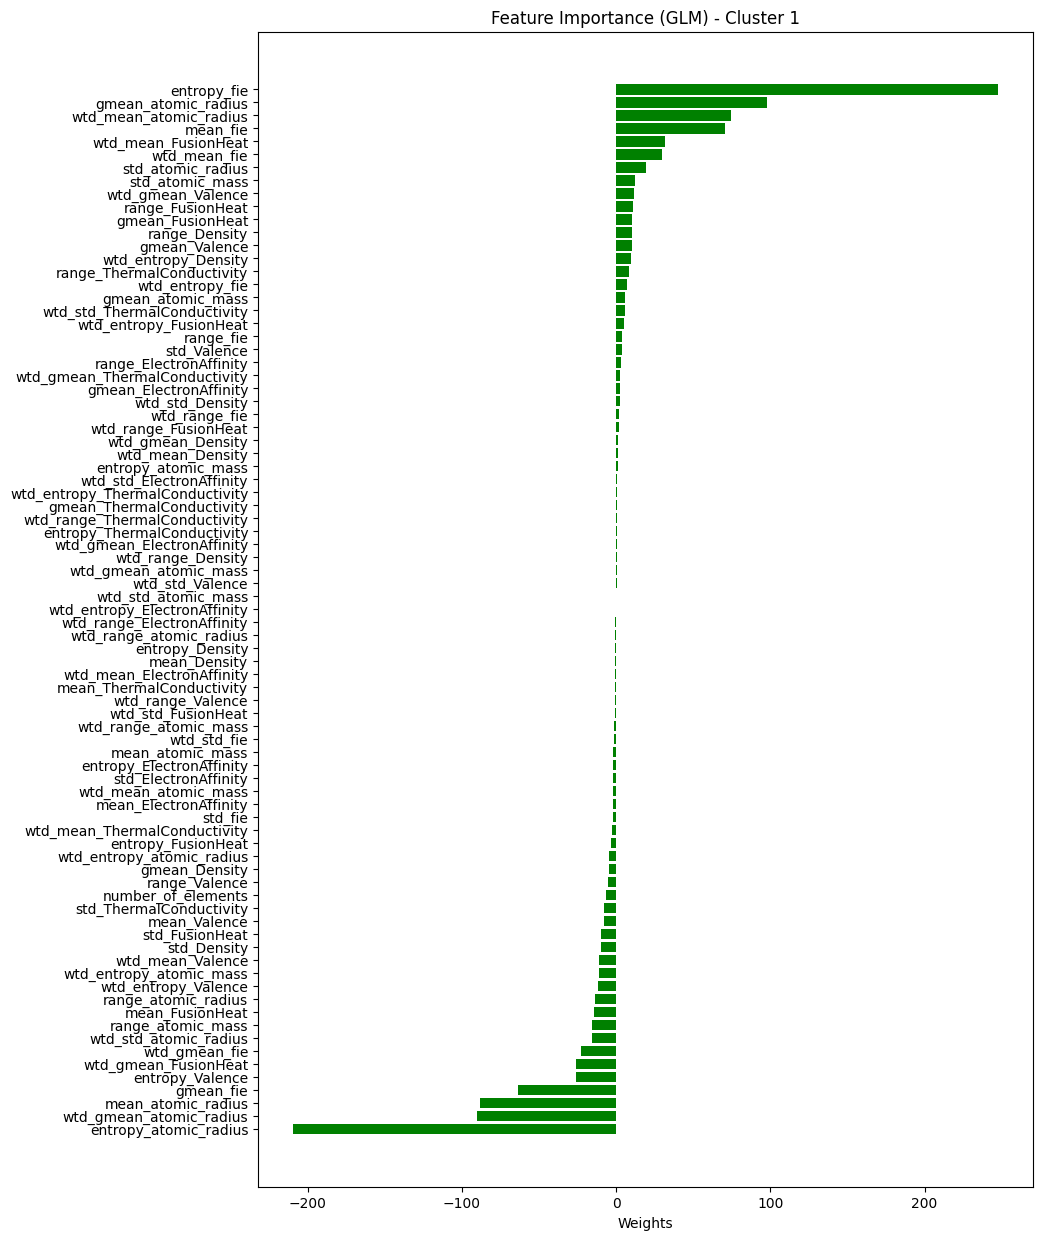

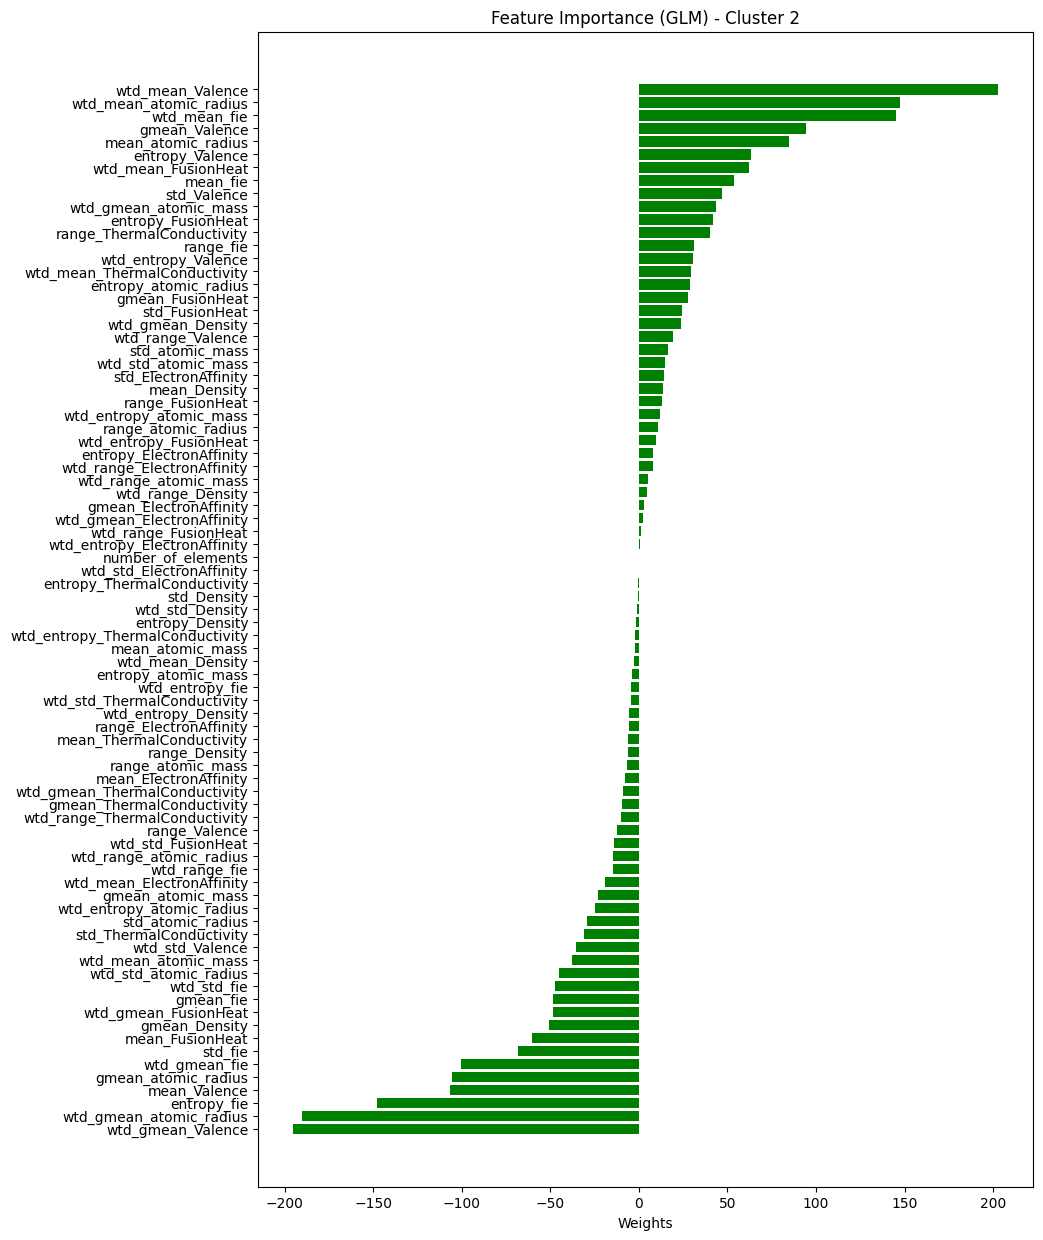

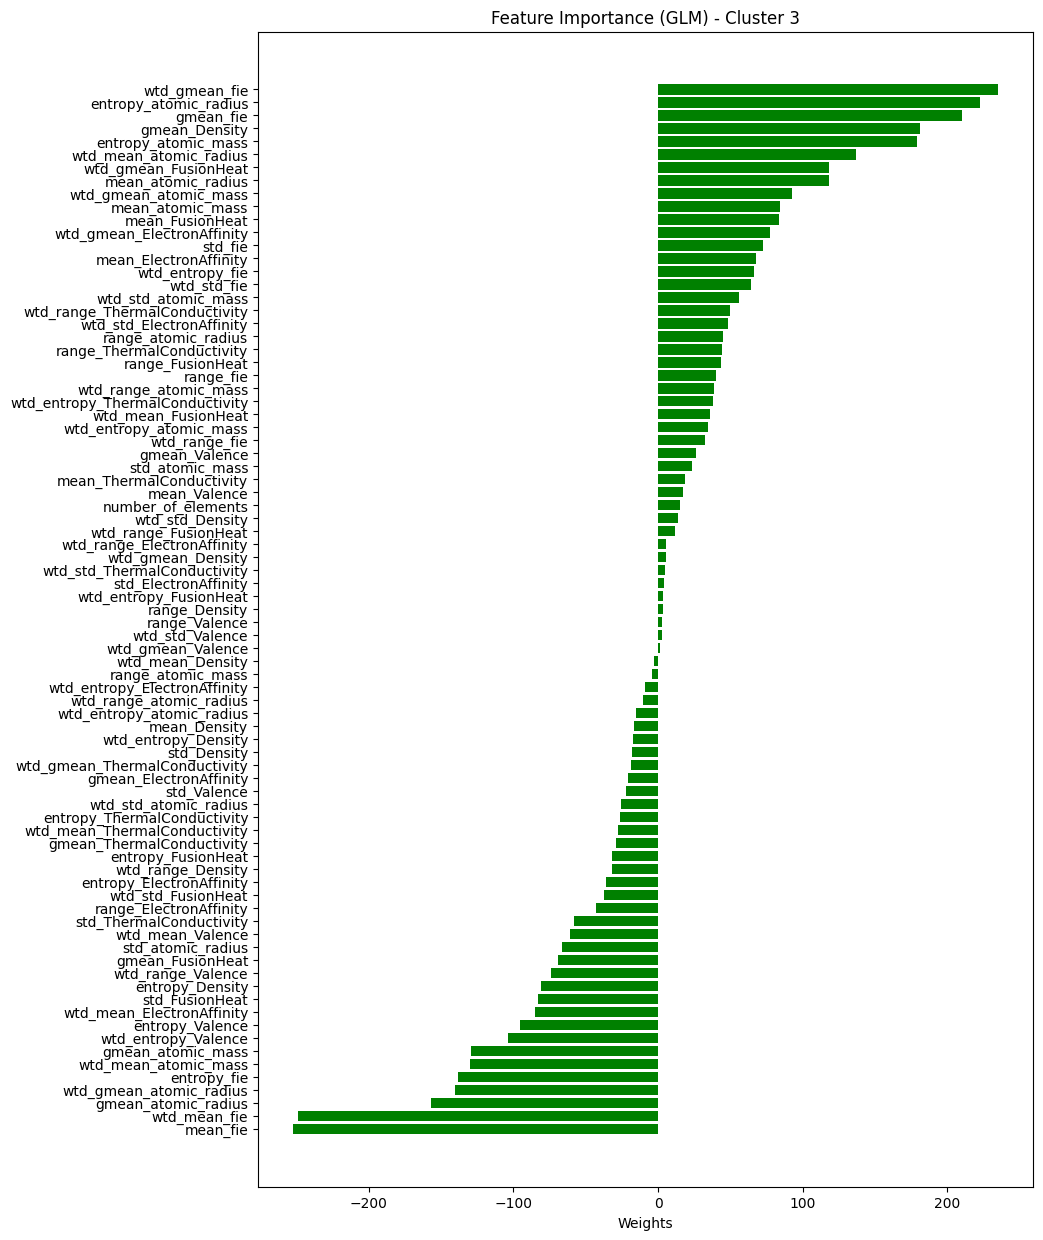

In [16]:
for cluster in valid_clusters[1:]:
    df_fi_per_cluster = glm.feature_importance(cluster=cluster, k=10)
    df_fi = pd.concat([df_fi, df_fi_per_cluster])

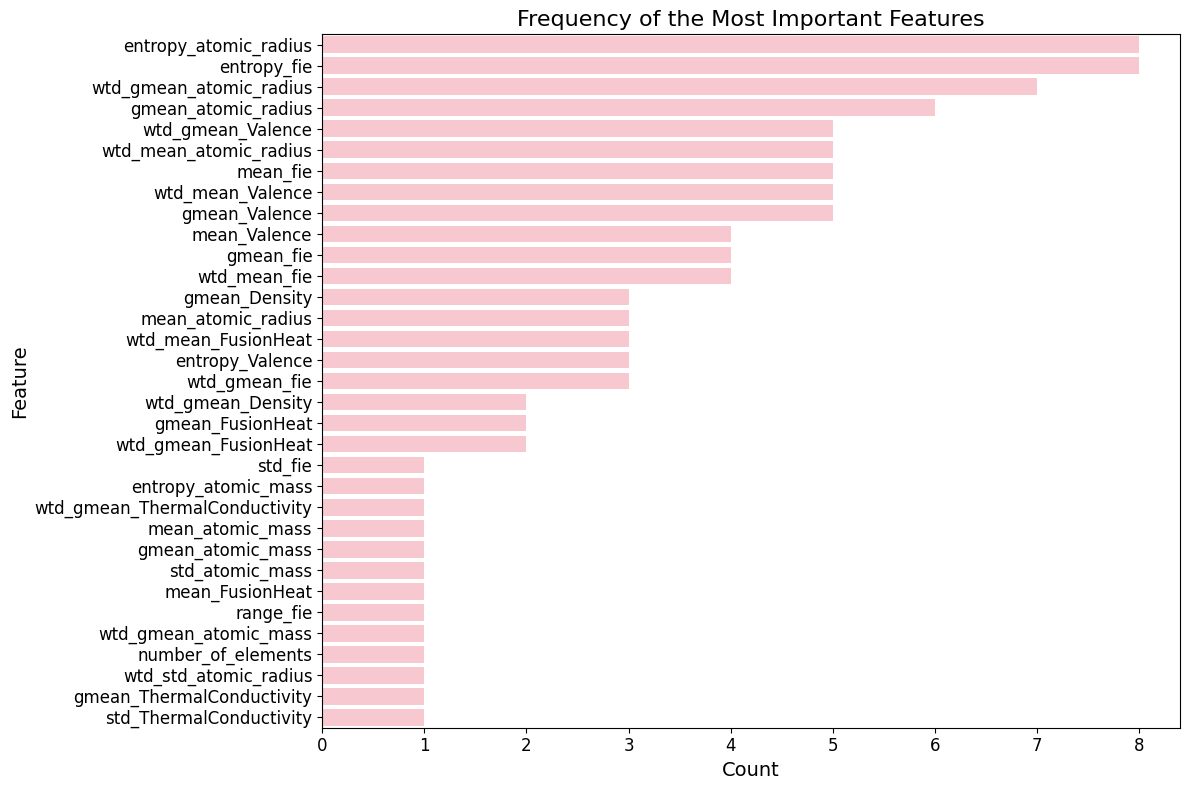

In [ ]:
plt.figure(figsize=(12, 8))

order = df_fi["Feature"].value_counts().index

sns.countplot(y="Feature", data=df_fi, order=order, color="pink")

plt.title("Frequency of the Most Important Features", fontsize=16)
plt.xlabel("Count", fontsize=14)
plt.ylabel("Feature", fontsize=14)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.tight_layout()
plt.show()


It´s interesting to notice that the feature that was considered as the most important, in a expressive way, for the model with all instances (``range_Thermal_Conductivity``) was not considered as the most important feature for any of the clusters. And isn´t in top 10, at all!

A fature that appeared most frequently in the top 10 most important features was ``entropy_atomic_radius``, in 8 clusters.

We can verify the distribution of this feature for each cluster and compare with the distribution with all the features.

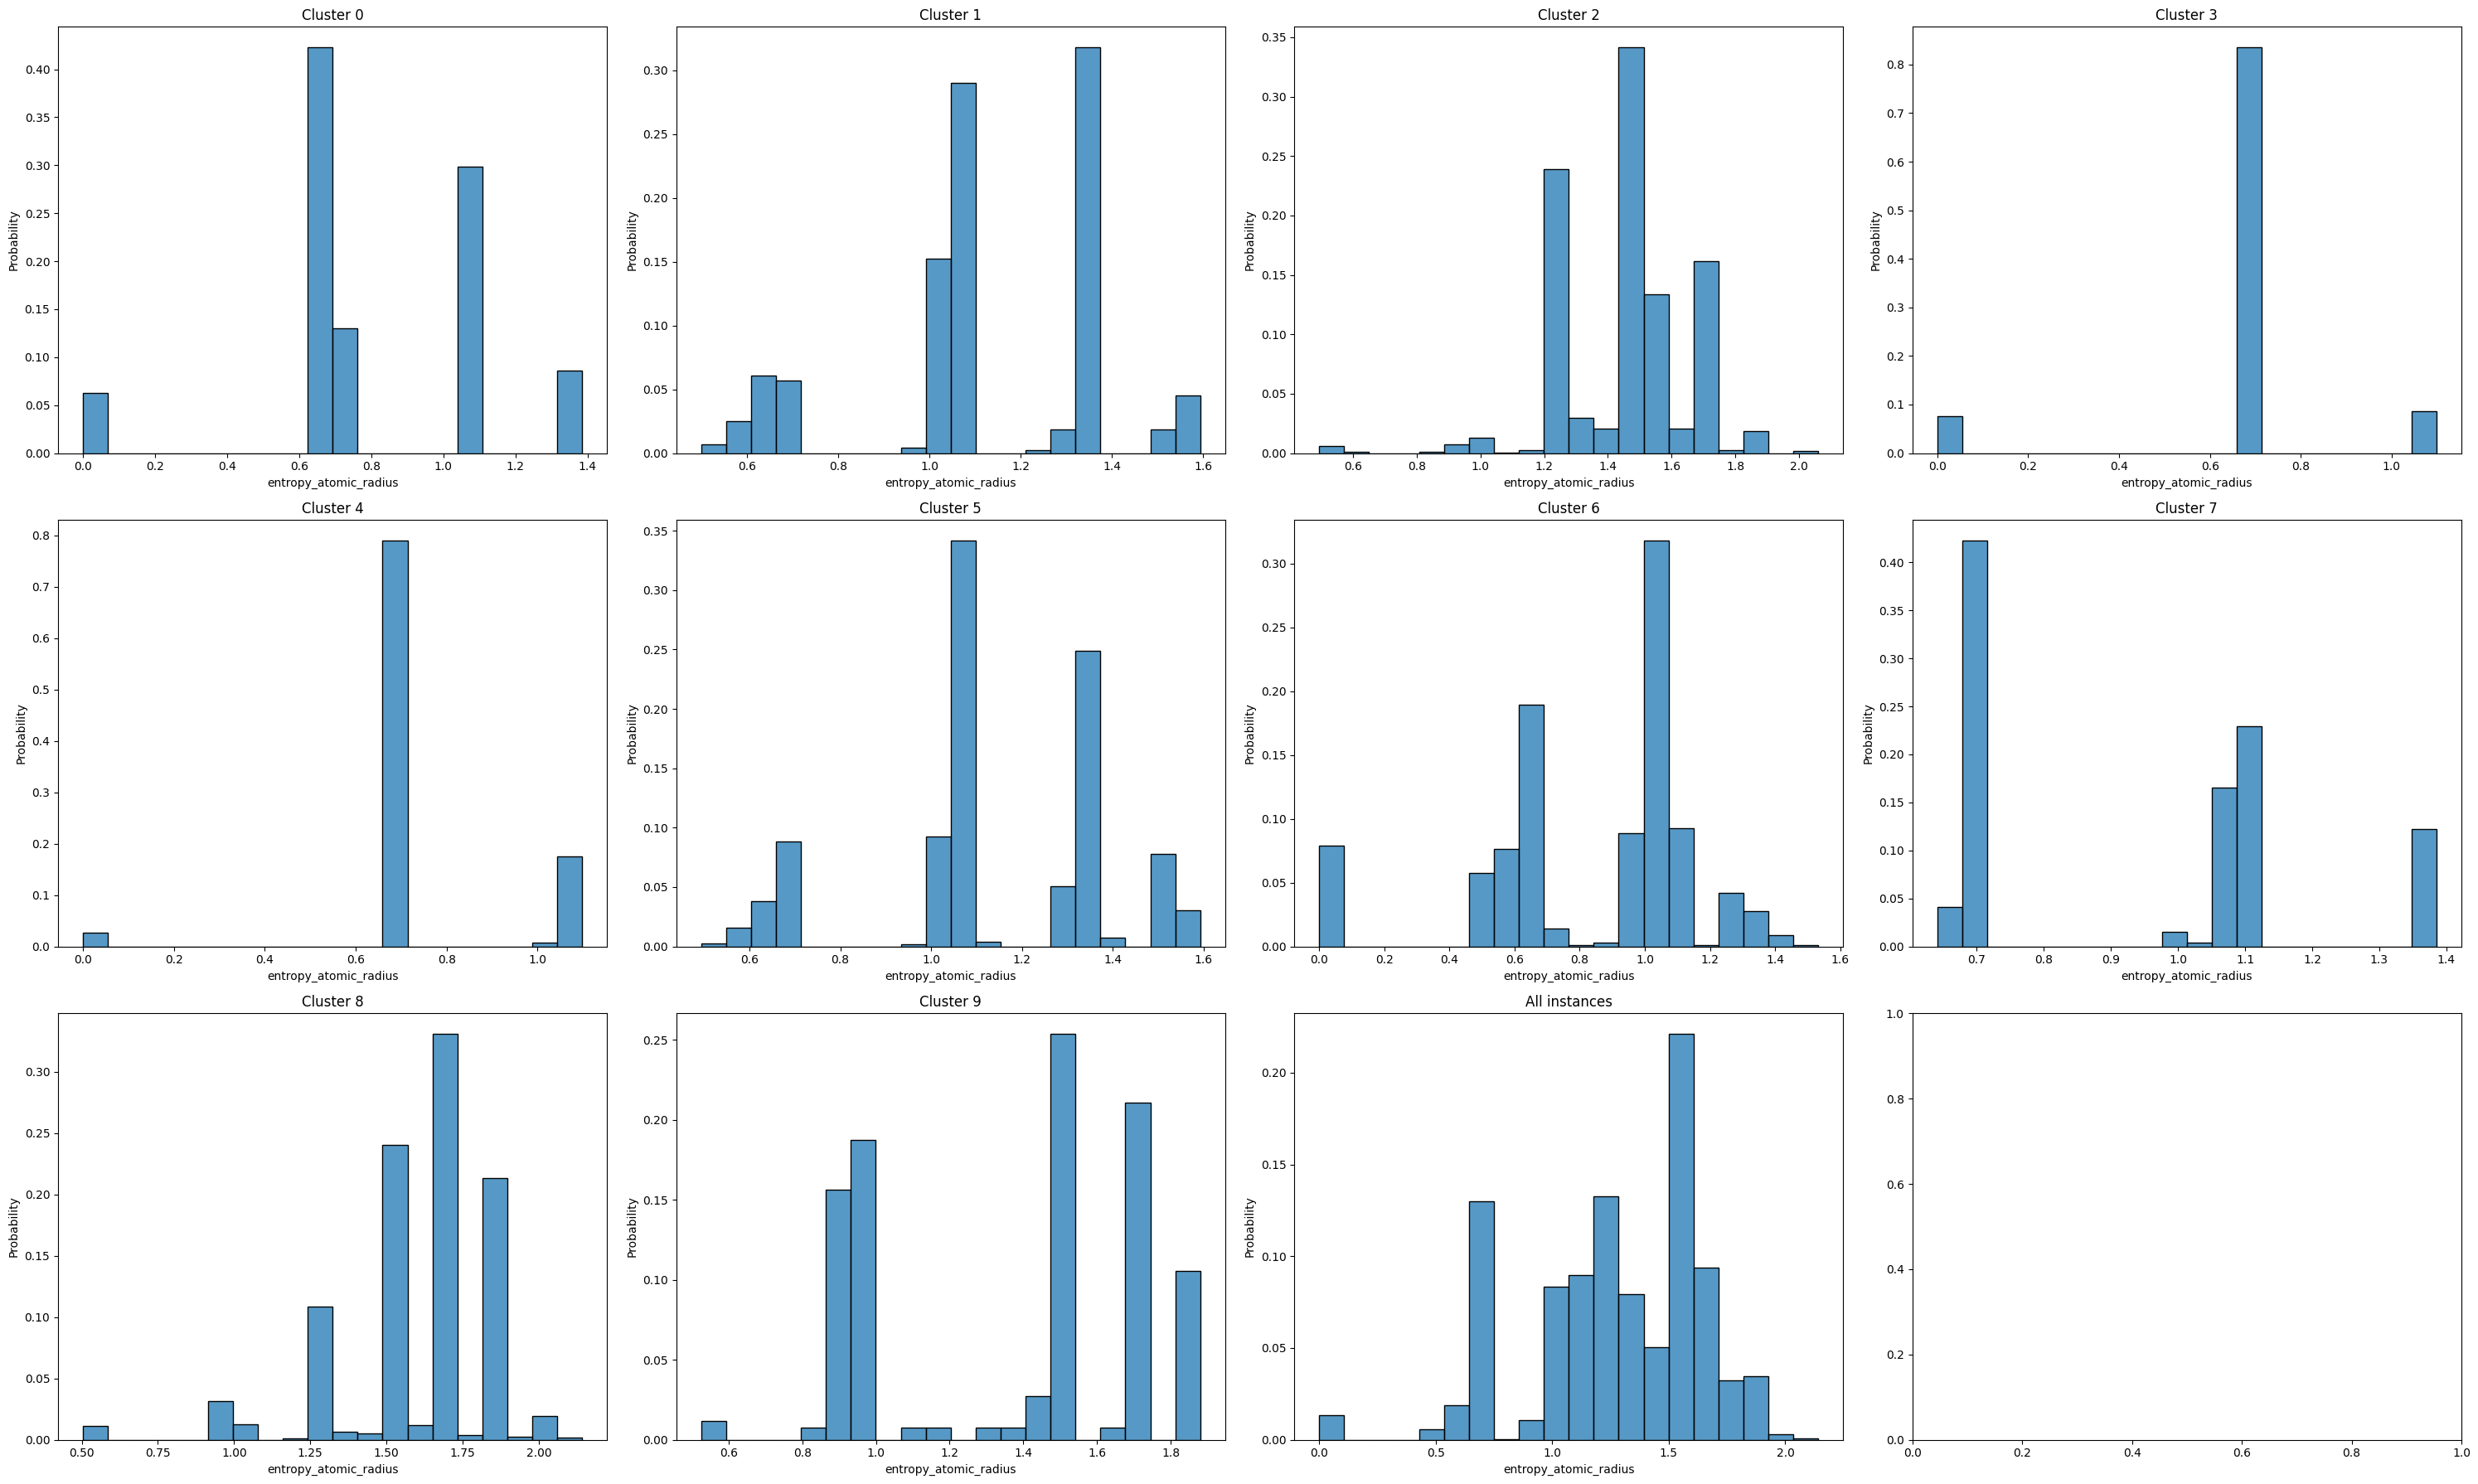

In [ ]:
fig, axs = plt.subplots(3, 4, figsize=(30, 18))
axs = axs.flatten()

count = 0
for cluster in valid_clusters: 
    idx = np.where(cluster_labels == cluster)[0]

    X_cluster = X_train.iloc[idx]
    y_cluster = y_train.iloc[idx]

    sns.histplot(X_cluster["entropy_atomic_radius"], ax=axs[count], kde=False, stat="probability", bins=20)  
    axs[count].set_title(f"Cluster {cluster}")

    count += 1
    if count >= len(X_train.columns): 
        break

sns.histplot(X_train["entropy_atomic_radius"], ax=axs[10], kde=False, stat="probability", bins=20) 
axs[10].set_title("All instances")

plt.tight_layout()
plt.show()

It´s evident that the clusters distributions are very different (between the clusters and in comparation to the histogram with all the instances). However, only based on these that it´s not possible to conclude something about the clustering

Besides that, we can make the analysis with SHapley Additive exPlanations (SHAP), what is a module that is able to explain the contribution of each feature to an individual prediction. By considering all instances, SHAP can determine the overall model importance. This method can be applied as a model-agnostic or type-specific explainer.


The theory behind SHAP is the *Game Theory*, by Lloyd Shapley. That provides tools for analyzing situations in which parties, called players, make decisions that are interdependent. In the context of machine learning, this theory is applied to measure each player's contribution - in this case, features - to the final outcome - model prediction.

To obtain SHAP values, the first step is to calculate the predictions of a baseline model (i.e., a model that doesn't use any features). Next, for each feature, SHAP computes the change in prediction when that feature is added to a subset of other features. Finally, the contribution of each feature is averaged across all possible combinations. This results in the SHAP value for that feature, which indicates how much it contributed, either positively or negatively, to the model’s prediction. [2][3]



Now, using the method "SHAP" of Clustering_GLM class, it´s possible to analyse the SHAP values for our clusters. Two types of plot can be used in this function: ``waterfall`` - for an overview considering all the instances - and ``summary_plot`` - for analyse an specific instance, mainly outliers. 

So, while we dont´t have a specific instance to analyse, let´s see the waterfall plot for each group. It´s important to notice that the function returns shap 

PermutationExplainer explainer: 2920it [02:02, 21.73it/s]                          
c:\Users\julia24002\OneDrive - ILUM ESCOLA DE CIÊNCIA\iniciacao_cientifica\IC---Interpretable-models-for-Tc-prediction\Other_files\..//Main_Scripts\script_glm_interpretability.py:125: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_cluster, color="coolwarm")


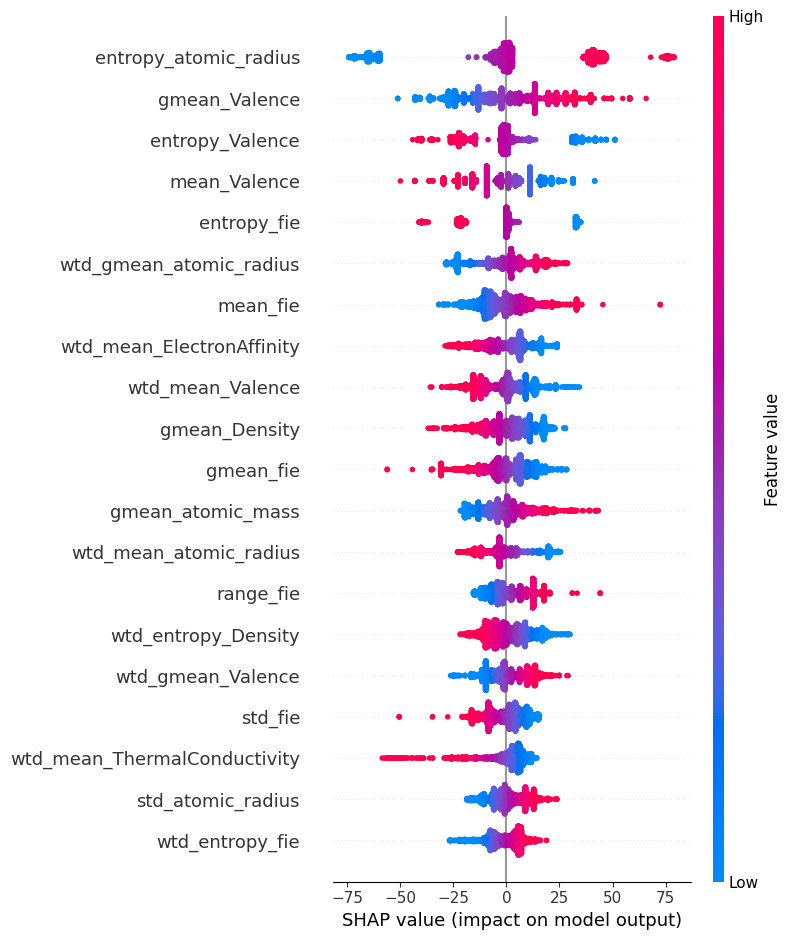

In [ ]:
cluster_0_sv = glm.shap(cluster=0)

PermutationExplainer explainer: 799it [00:29, 17.34it/s]                         
c:\Users\julia24002\OneDrive - ILUM ESCOLA DE CIÊNCIA\iniciacao_cientifica\IC---Interpretable-models-for-Tc-prediction\Other_files\..//Main_Scripts\script_glm_interpretability.py:125: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_cluster, color="coolwarm")


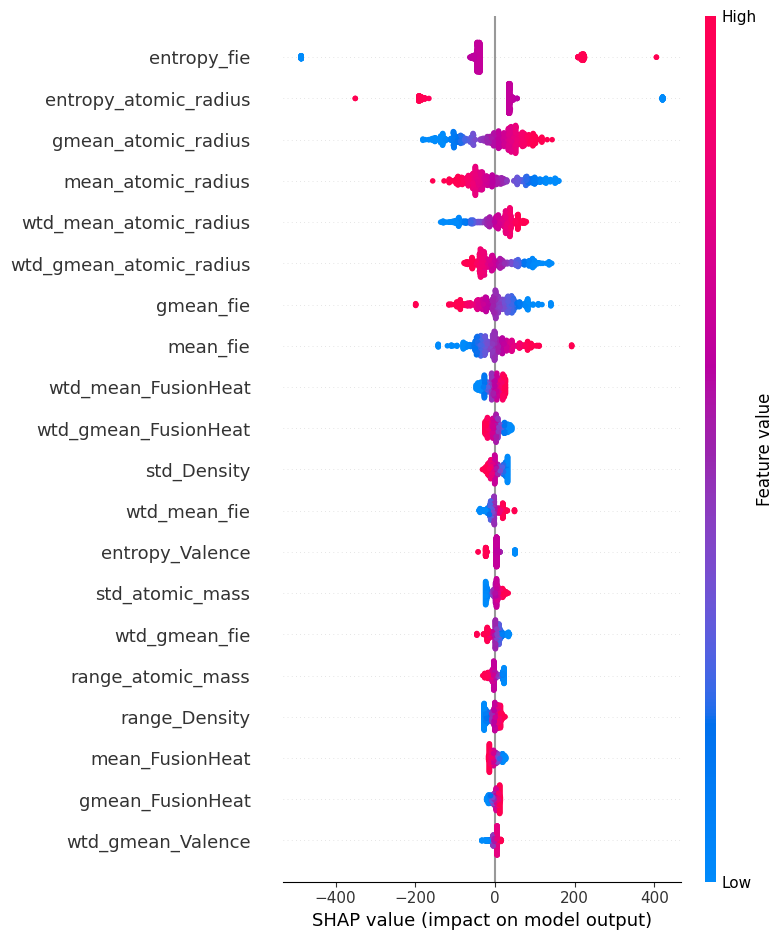

In [ ]:
cluster_1_sv = glm.shap(cluster=1)

In [ ]:
cluster_2_sv = glm.shap(cluster=2)

NameError: name 'glm' is not defined

### 🗂️ **References!**

[1] Sun, K., Lan, T., Goh, Y. M., Safiena, S., Huang, Y.-H., Lytle, B., & He, Y. (2024). An interpretable clustering approach to safety climate analysis: Examining driver group distinctions. Accident Analysis & Prevention, 196, 107420. https://doi.org/10.1016/j.aap.2023.107420

[2] Welcome to the SHAP documentation—SHAP latest documentation. ([s.d.]). Recuperado 29 de agosto de 2025, de https://shap.readthedocs.io/en/latest/

[3] Cassargroup/explicable-ai-supercondutores. (2025). [Jupyter Notebook]. CassarGroup. https://github.com/CassarGroup/Explicable-AI-Supercondutores (Trabalho original publicado 2025)
